<a href="https://colab.research.google.com/github/Miyashita1111/multimodal-active/blob/master/Copy_of_lecture06_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第6回講義 宿題

## 課題
今Lessonで学んだことに工夫を加えて，FCNでより高性能なVOC2011データセットのセグメンテーションモデルを実装しましょう．

## 目標値
mean-IoU 0.4

## ルール
- 訓練データは`x_train`，`y_train`，テストデータは`x_test`で与えられます．
- 予測結果は，(21, 224, 224)のセグメンテーションマスクとしてください．
- **下のセルで指定されている`x_train`，`y_train`以外の学習データは使わないでください．**
-　事前学習モデルの利用は,
backboneでの使用のみ可とします．
    - torchvision.models.segmentation で提供されているような，ライブラリで実装されている FCN の利用は禁止とします．

## 提出方法

- 2つのファイルを提出していただきます．
    1. テストデータ (`x_test`) に対する予測マスクをnpy形式で保存し，**Omnicampusの宿題タブから「第6回 深層学習と画像認識」を選択して**提出してください．
    2. それに対応するpythonのコードを　ファイル＞ダウンロード＞.pyをダウンロード　から保存し，**Omnicampusの宿題タブから「第6回 深層学習と画像認識 (code)」を選択して**提出してください．pythonファイル自体の提出ではなく，「提出内容」の部分にコード全体をコピー&ペーストしてください．
      
- なお，採点は1で行い，2はコードの確認用として利用します（成績優秀者はコード内容を公開させていただくかもしれません）．コードの内容を変更した場合は，**1と2の両方を提出し直してください**．

### 評価方法

- 予測ラベルの`y_test`に対するmean-IoUで評価します．
- 即時採点しLeader Boardを更新します（採点スケジュールは別アナウンス）．
- 締切時の点数を最終的な評価とします．

In [1]:
# ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 作業ディレクトリを指定
work_dir = 'drive/MyDrive/Colab Notebooks/DLBasics2025_colab'

### データの読み込み（この部分は修正しないでください）

In [3]:
import random

import numpy as np
import pandas as pd
import torch
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

#学習データ
x_train = np.load(work_dir + '/Lecture06/data/x_train.npy', allow_pickle=True)
y_train = np.load(work_dir + '/Lecture06/data/y_train.npy', allow_pickle=True)

#テストデータ
x_test = np.load(work_dir + '/Lecture06/data/x_test.npy', allow_pickle=True)

# 実装の都合上，コンストラクタ内で画像をリサイズ
class train_dataset(torch.utils.data.Dataset):
    def __init__(self, x_train, y_train):
        self.x_train = []
        self.y_train = []
        for i in range(x_train.shape[0]):
            self.x_train.append(transforms.Resize((224, 224))(Image.fromarray(np.uint8(x_train[i]))))
            self.y_train.append(transforms.Resize((224, 224))(Image.fromarray(np.uint8(y_train[i]))))
        self.transform = transforms.ToTensor()
        self.target_transform = transforms.ToTensor()

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        return self.transform(self.x_train[idx]), self.target_transform(self.y_train[idx])

class test_dataset(torch.utils.data.Dataset):
    def __init__(self, x_test):
        self.x_test = []
        for i in range(x_test.shape[0]):
            self.x_test.append(transforms.Resize((224, 224))(Image.fromarray(np.uint8(x_test[i]))))
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.x_test)

    def __getitem__(self, idx):
        return self.transform(self.x_test[idx])

trainval_data = train_dataset(x_train, y_train)
test_data = test_dataset(x_test)

### FCN の実装

In [4]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
def fix_seed(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


fix_seed(seed=42)

# データの分割
val_size = 100
train_data, val_data = torch.utils.data.random_split(trainval_data, [len(trainval_data)-val_size, val_size])  # 訓練データと検証データに分割

num_classes = 21

# 前処理の定義
def TargetToTensor(target):
    target = np.array(target)
    target[target > 20] = 0 # labelを0-20の合計21クラスに限定（objectのエッジを消す）
    target = torch.from_numpy(target).type(torch.long)
    target = F.one_hot(target, num_classes=num_classes).permute(2,0,1).type(torch.float)
    return target  # (21, 224, 224)

image_transform = transforms.Compose([
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    transforms.Lambda(lambda target: TargetToTensor(target))
])

trainval_data.transform = image_transform
trainval_data.target_transform = target_transform
test_data.transform = image_transform

batch_size=16

# dataloaderの定義
dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False
)
dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

In [16]:
# FCNの定義
class FCN(nn.Module):
    def __init__(self, backbone, num_classes=21):
        super(FCN, self).__init__()
        # backbone
        self.backbone = backbone
        # convolution
        self.FCNhead =  nn.Sequential(nn.Conv2d(2048, 512, 3, padding=1, bias=False),
                                      nn.BatchNorm2d(512),
                                      nn.ReLU(),
                                      nn.Dropout(0.1),
                                      nn.Conv2d(512, num_classes, 1))# WRITE ME

    def forward(self, x):
        input_shape = x.shape[-2:] # shape: (224, 224)
        x = self.backbone(x) # WRITE ME  # backboneでの処理 (512, 7, 7)
        x =  self.FCNhead(x)# WRITE ME  # FCNheadでの処理 (21, 7 ,7 )
        x = F.interpolate(x, size=input_shape, mode="bilinear",align_corners=False)  # WRITE ME
        return x

backbone = torchvision.models.resnet50(pretrained=torchvision.models.ResNet50_Weights.DEFAULT)
backbone = nn.Sequential(*list(backbone.children())[:-2])  # GAP層とFC層を外す

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
# 下記リンク先のmIoU実装を利用
# https://github.com/wkentaro/pytorch-fcn/blob/master/torchfcn/utils.py
class mIoUScore(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def _fast_hist(self, label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask], minlength=n_class ** 2
        ).reshape(n_class, n_class)
        return hist

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist(lt.flatten(), lp.flatten(), self.n_classes)

    def get_scores(self):
        hist = self.confusion_matrix
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iou = np.nanmean(iou)
        return mean_iou

    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))

In [18]:
model = FCN(backbone=backbone, num_classes=num_classes)
model.to(device)

# optimizer, loss function, metricsの定義
loss_fn = nn.BCEWithLogitsLoss()
metrics = mIoUScore(num_classes)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

n_epochs = 10

In [19]:
# modelの学習
for epoch in range(n_epochs):
    train_losses = []
    valid_losses = []
    metrics.reset()

    model.train()
    with tqdm(total=len(dataloader_train), unit="batch") as pbar:
        pbar.set_description(f"[train] Epoch {epoch+1}/{n_epochs}")
        for image, target in dataloader_train:
            optimizer.zero_grad()
            image, target = image.to(device), target.to(device)
            output = model(image)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            pbar.set_postfix(loss=np.array(train_losses).mean())
            pbar.update(1)

    model.eval()
    with tqdm(total=len(dataloader_valid), unit="batch") as pbar:
        pbar.set_description(f"[valid] Epoch {epoch+1}/{n_epochs}")
        for image, target in dataloader_valid:
            image, target = image.to(device), target.to(device)
            output = model(image)
            loss = loss_fn(output, target)
            valid_losses.append(loss.item())
            metrics.update(target.argmax(1).cpu().numpy(), output.argmax(1).cpu().numpy())
            pbar.set_postfix(loss=np.array(valid_losses).mean(), mIoU=metrics.get_scores())
            pbar.update(1)

/tmp/ipython-input-4090186985.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(dataloader_train), unit="batch") as pbar:


  0%|          | 0/114 [00:00<?, ?batch/s]

/tmp/ipython-input-4090186985.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(dataloader_valid), unit="batch") as pbar:


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

In [21]:
import random
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models.segmentation import (
    deeplabv3_resnet50,
    DeepLabV3_ResNet50_Weights
)
from tqdm import tqdm_notebook as tqdm
from PIL import Image

# ============================================================
# 1. データ読み込み
# ============================================================
# work_dir は自分の環境で既に定義されている前提
x_train = np.load(work_dir + '/Lecture06/data/x_train.npy', allow_pickle=True)
y_train = np.load(work_dir + '/Lecture06/data/y_train.npy', allow_pickle=True)
x_test  = np.load(work_dir + '/Lecture06/data/x_test.npy',  allow_pickle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)

def fix_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

fix_seed(42)

num_classes = 21  # クラス数（背景含む）

# ============================================================
# 2. Target / Transform 定義
# ============================================================
def TargetToTensor(mask_pil):
    """
    mask_pil: PIL.Image (H, W), 各ピクセルがクラスID
    出力: torch.LongTensor (H, W)
    """
    mask = np.array(mask_pil)
    mask[mask > 20] = 0  # 0〜20 にクリップ
    return torch.from_numpy(mask).long()

# DeepLab(ResNet) 用の正規化
image_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# 「画像＋マスクに同じジオメトリ」をかけるための joint transform
import torchvision.transforms.functional as TF

class SegRandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, img, mask):
        if random.random() < self.p:
            img = TF.hflip(img)
            mask = TF.hflip(mask)
        return img, mask

# ============================================================
# 3. Dataset 定義（train/val 用・test 用）
# ============================================================
class TrainValDataset(torch.utils.data.Dataset):
    def __init__(self, x, y,
                 joint_transform=None,
                 img_transform=None,
                 mask_transform=None):
        """
        x, y: numpy array (N, H, W[, C])
        """
        self.x = x
        self.y = y
        self.joint_transform = joint_transform
        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        img = Image.fromarray(np.uint8(self.x[idx])).convert("RGB")
        mask = Image.fromarray(np.uint8(self.y[idx]))  # single-channel

        # 224x224 にリサイズ
        img = img.resize((224, 224), Image.BILINEAR)
        mask = mask.resize((224, 224), Image.NEAREST)

        if self.joint_transform is not None:
            img, mask = self.joint_transform(img, mask)

        if self.img_transform is not None:
            img = self.img_transform(img)

        if self.mask_transform is not None:
            mask = self.mask_transform(mask)

        return img, mask

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, x, img_transform=None):
        self.x = x
        self.img_transform = img_transform

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        img = Image.fromarray(np.uint8(self.x[idx])).convert("RGB")
        img = img.resize((224, 224), Image.BILINEAR)
        if self.img_transform is not None:
            img = self.img_transform(img)
        return img

# ============================================================
# 4. train / val 分割 & Transform 設定
# ============================================================
val_size = 100
N = x_train.shape[0]
indices = np.arange(N)
np.random.shuffle(indices)
val_idx = indices[:val_size]
train_idx = indices[val_size:]

x_tr, y_tr = x_train[train_idx], y_train[train_idx]
x_val, y_val = x_train[val_idx],  y_train[val_idx]

# 画像用 transform
img_transform_train = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    image_normalize,
])

img_transform_val = transforms.Compose([
    transforms.ToTensor(),
    image_normalize,
])

mask_transform = transforms.Lambda(lambda t: TargetToTensor(t))
joint_transform_train = SegRandomHorizontalFlip(p=0.5)

train_data = TrainValDataset(
    x_tr, y_tr,
    joint_transform=joint_transform_train,
    img_transform=img_transform_train,
    mask_transform=mask_transform
)

val_data = TrainValDataset(
    x_val, y_val,
    joint_transform=None,         # Val では拡張しない
    img_transform=img_transform_val,
    mask_transform=mask_transform
)

test_data = TestDataset(
    x_test,
    img_transform=img_transform_val
)

batch_size = 16

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False
)
dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

# ============================================================
# 5. mIoU の実装
# ============================================================
class mIoUScore(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    def _fast_hist(self, label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask].astype(int),
            minlength=n_class ** 2
        ).reshape(n_class, n_class)
        return hist

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist(lt.flatten(), lp.flatten(), self.n_classes)

    def get_scores(self):
        hist = self.confusion_matrix
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iou = np.nanmean(iou)
        return float(mean_iou)

    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes), dtype=np.int64)

metrics = mIoUScore(num_classes)

# ============================================================
# 6. DeepLabV3 + ResNet50 モデル定義
# ============================================================
weights = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
model = deeplabv3_resnet50(weights=weights)

# 出力クラス数の変更
model.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)
if model.aux_classifier is not None:
    model.aux_classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)

model.to(device)

# ============================================================
# 7. 損失関数・optimizer・scheduler
# ============================================================
loss_fn = nn.CrossEntropyLoss()

# パラメータを backbone / head で分けて LR 調整
backbone_params = []
head_params = []
for name, param in model.named_parameters():
    if not param.requires_grad:
        continue
    if "classifier" in name or "aux_classifier" in name:
        head_params.append(param)
    else:
        backbone_params.append(param)

optimizer = optim.AdamW([
    {"params": backbone_params, "lr": 1e-5},
    {"params": head_params,    "lr": 1e-4},
], weight_decay=1e-4)

n_epochs = 10
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# ============================================================
# 8. 学習ループ
# ============================================================
for epoch in range(n_epochs):
    # ---------- train ----------
    model.train()
    train_losses = []
    with tqdm(total=len(dataloader_train), unit="batch") as pbar:
        pbar.set_description(f"[train] Epoch {epoch+1}/{n_epochs}")
        for images, targets in dataloader_train:
            images = images.to(device)         # (B, 3, H, W)
            targets = targets.to(device)       # (B, H, W)

            optimizer.zero_grad()
            out_dict = model(images)
            outputs = out_dict["out"]          # (B, C, H, W)

            loss = loss_fn(outputs, targets)
            # aux_loss を使いたければコメントアウトを外す
            if "aux" in out_dict:
                aux_outputs = out_dict["aux"]
                loss = loss + 0.4 * loss_fn(aux_outputs, targets)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            pbar.set_postfix(loss=np.mean(train_losses))
            pbar.update(1)

    # ---------- valid ----------
    model.eval()
    valid_losses = []
    metrics.reset()
    with torch.no_grad():
        with tqdm(total=len(dataloader_valid), unit="batch") as pbar:
            pbar.set_description(f"[valid] Epoch {epoch+1}/{n_epochs}")
            for images, targets in dataloader_valid:
                images = images.to(device)
                targets = targets.to(device)

                out_dict = model(images)
                outputs = out_dict["out"]

                loss = loss_fn(outputs, targets)
                if "aux" in out_dict:
                    aux_outputs = out_dict["aux"]
                    loss = loss + 0.4 * loss_fn(aux_outputs, targets)

                valid_losses.append(loss.item())

                preds = outputs.argmax(1).cpu().numpy()   # (B, H, W)
                gts   = targets.cpu().numpy()             # (B, H, W)
                metrics.update(gts, preds)

                pbar.set_postfix(
                    loss=np.mean(valid_losses),
                    mIoU=metrics.get_scores()
                )
                pbar.update(1)

    scheduler.step()

print("Training finished!")


device: cuda


/tmp/ipython-input-495092049.py:262: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(dataloader_train), unit="batch") as pbar:


  0%|          | 0/114 [00:00<?, ?batch/s]

/tmp/ipython-input-495092049.py:290: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(dataloader_valid), unit="batch") as pbar:


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

Training finished!


In [23]:
# 提出ファイルの作成
model.eval()
y_pred = []

for x in dataloader_test:
    x = x.to(device)

    # 順伝播
    # DeepLabV3モデルはOrderedDictを返すため、'out'キーから予測を取得
    pred = model(x)
    y_pred.extend(pred['out'].cpu().detach().numpy())

y_pred = np.array(y_pred)
y_pred = y_pred.argmax(1).astype(np.uint8)
np.save(work_dir + '/Lecture06/submission_pred_06.npy', y_pred)

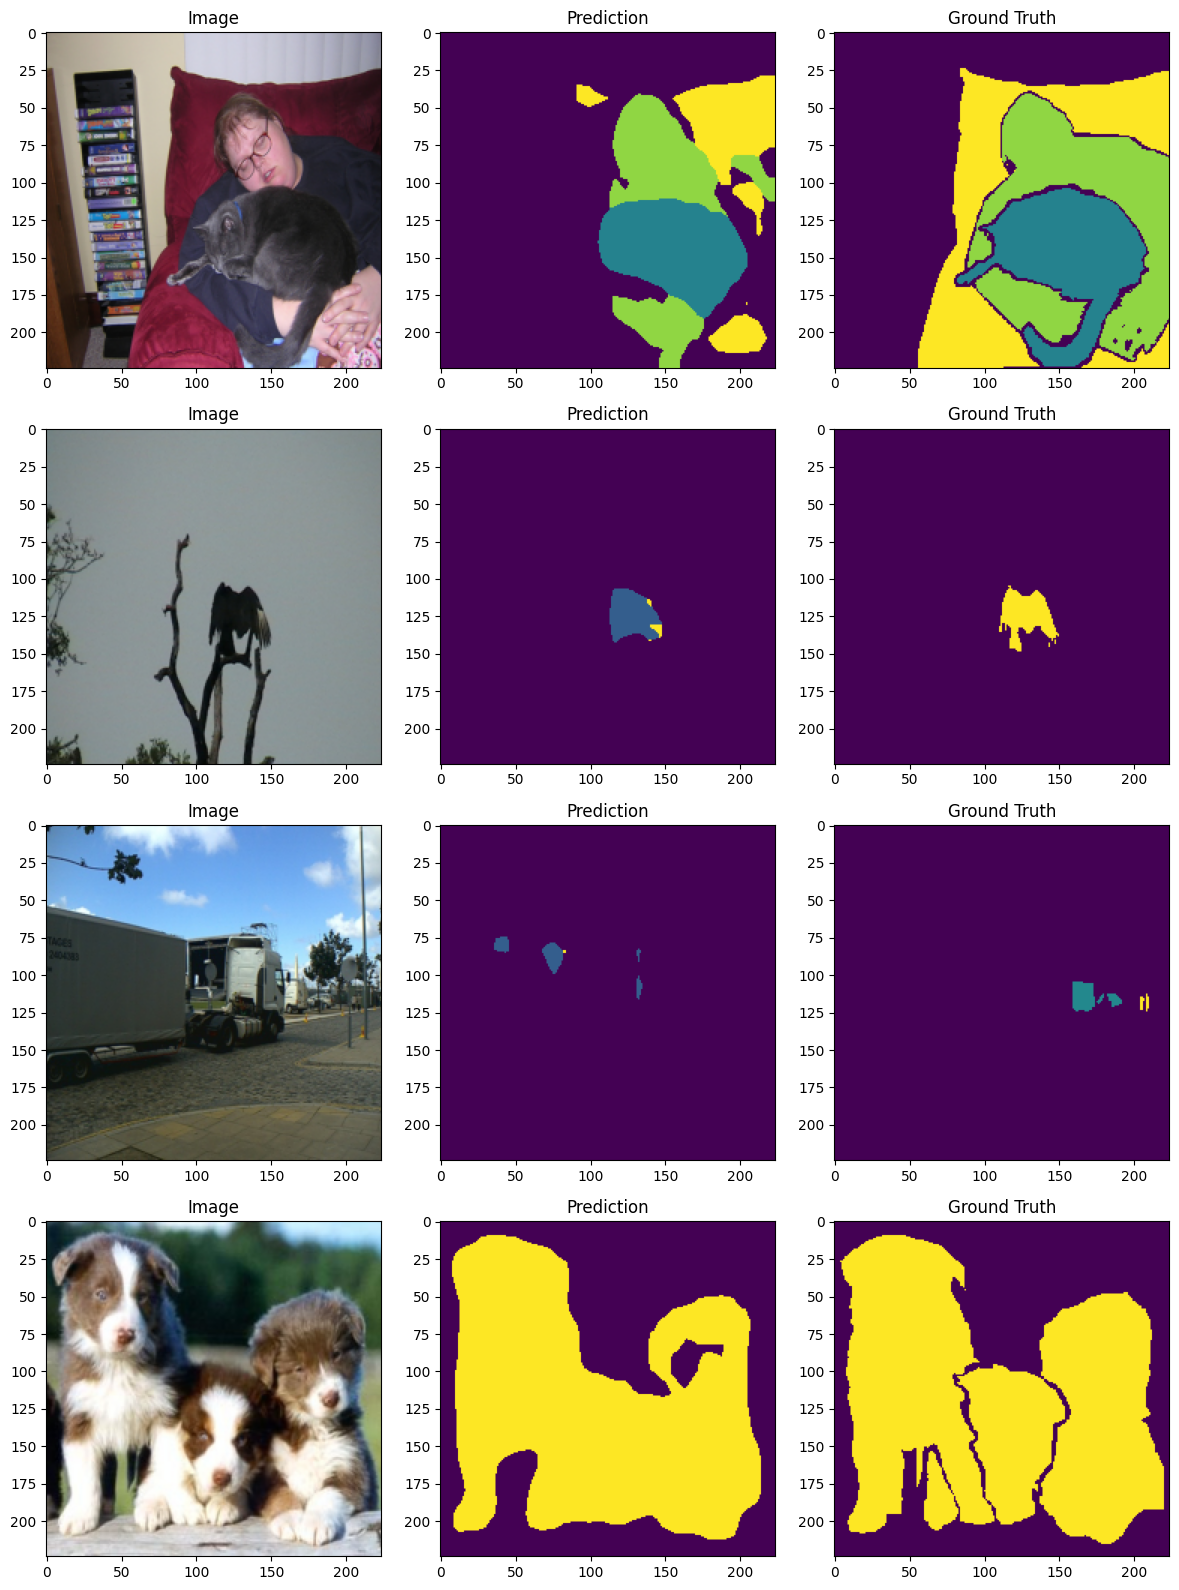

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 16))
model.eval()

for i in range(4):
    img, gt = val_data[i]                # img: (3,H,W), gt: (H,W)
    img_np = img.cpu().numpy().transpose(1, 2, 0)

    # 推論
    with torch.no_grad():
        out = model(img.unsqueeze(0).to(device))["out"]  # (1, C, H, W)
        pred = out.argmax(dim=1).cpu().numpy()[0]        # (H, W)

    # 画像を [0,1] に戻すために正規化を解除（任意）
    # 現状は mean/std をかけているので、可視化時は戻すと綺麗
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img_show = img_np * std + mean
    img_show = np.clip(img_show, 0, 1)

    # ---- Plot ----
    plt.subplot(4, 3, 3*i + 1)
    plt.title("Image")
    plt.imshow(img_show)

    plt.subplot(4, 3, 3*i + 2)
    plt.title("Prediction")
    plt.imshow(pred)

    plt.subplot(4, 3, 3*i + 3)
    plt.title("Ground Truth")
    plt.imshow(gt.cpu().numpy())

plt.tight_layout()
plt.show()
